<a href="https://colab.research.google.com/github/shadab4150/Landscape-Image-Classification/blob/master/Intel_Landscape_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!unzip '/content/drive/My Drive/intel-image-classification/seg_train.zip' -d '/content/train/'

Archive:  /content/drive/My Drive/intel-image-classification/seg_train.zip
   creating: /content/train/seg_train/
   creating: /content/train/seg_train/buildings/
  inflating: /content/train/seg_train/buildings/0.jpg  
  inflating: /content/train/seg_train/buildings/10006.jpg  
  inflating: /content/train/seg_train/buildings/1001.jpg  
  inflating: /content/train/seg_train/buildings/10014.jpg  
  inflating: /content/train/seg_train/buildings/10018.jpg  
  inflating: /content/train/seg_train/buildings/10029.jpg  
  inflating: /content/train/seg_train/buildings/10032.jpg  
  inflating: /content/train/seg_train/buildings/10056.jpg  
  inflating: /content/train/seg_train/buildings/1009.jpg  
  inflating: /content/train/seg_train/buildings/10113.jpg  
  inflating: /content/train/seg_train/buildings/1012.jpg  
  inflating: /content/train/seg_train/buildings/10126.jpg  
  inflating: /content/train/seg_train/buildings/10144.jpg  
  inflating: /content/train/seg_train/buildings/10151.jpg  
  in

In [0]:
import pandas as pd
import numpy as np
from pathlib import Path
import fastai
from fastai.vision import *
from fastai.callbacks import TrackerCallback, SaveModelCallback
import os
import warnings
warnings.filterwarnings("ignore")

In [0]:
path = Path('/content/train/seg_train/')

In [6]:
path.ls()

[PosixPath('/content/train/seg_train/forest'),
 PosixPath('/content/train/seg_train/glacier'),
 PosixPath('/content/train/seg_train/mountain'),
 PosixPath('/content/train/seg_train/street'),
 PosixPath('/content/train/seg_train/buildings'),
 PosixPath('/content/train/seg_train/sea')]

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.3,
        ds_tfms=get_transforms(do_flip=True,max_warp=0.1), size=140, bs=128).normalize(imagenet_stats)

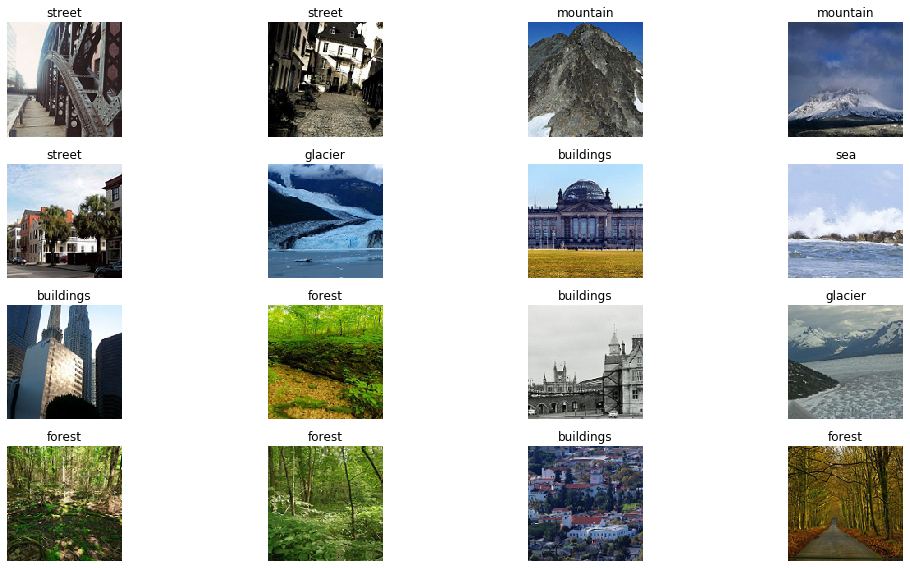

In [8]:
data.show_batch(rows=4,figsize=(16,8))

In [0]:
arch = models.resnet50

In [10]:
learn = cnn_learner(data, arch, metrics=[error_rate,accuracy],model_dir='/content/train/' ).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 302MB/s]


epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


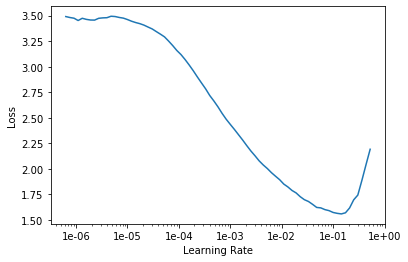

In [11]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr=0.02

In [13]:
learn.fit_one_cycle(6,slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.496050,0.331068,0.099217,0.900783,01:04
1,0.415065,0.381088,0.114873,0.885127,01:04
2,0.274501,0.244924,0.081213,0.918787,01:03
3,0.211165,0.193761,0.065558,0.934442,01:02
4,0.160901,0.192087,0.064971,0.935029,01:00
5,0.130441,0.192196,0.063014,0.936986,00:59


In [14]:
interp = ClassificationInterpretation.from_learner(learn)

In [15]:
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

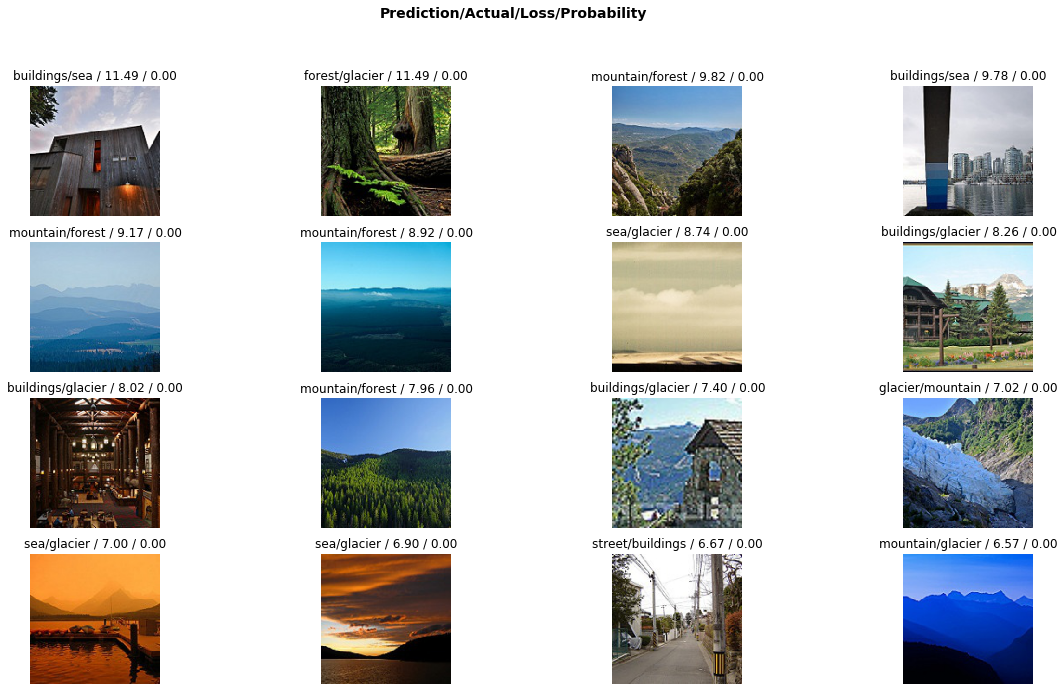

In [16]:
interp.plot_top_losses(16, figsize=(20,11))

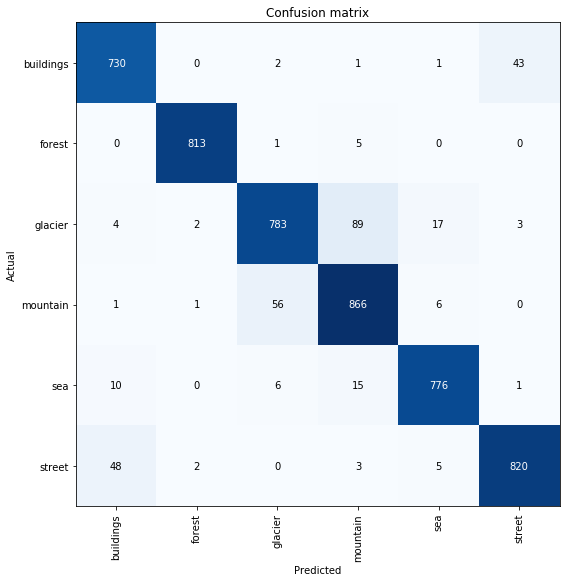

In [17]:
interp.plot_confusion_matrix(figsize=(10,8))

In [0]:
learn.save('model_intel')

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


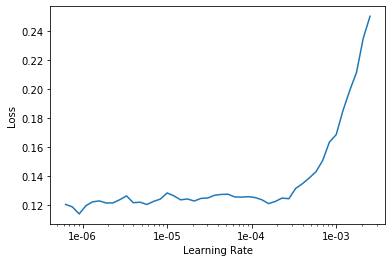

In [19]:
learn.load('model_intel')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [20]:
import gc
gc.collect()

5930

In [21]:
learn.fit_one_cycle(5,slice(1e-5,1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.122415,0.194170,0.063796,0.936204,01:02
1,0.125452,0.197880,0.065166,0.934834,01:02
2,0.097028,0.190041,0.062035,0.937965,01:01
3,0.077248,0.195647,0.061057,0.938943,01:01
4,0.061582,0.195220,0.060665,0.939335,01:03


In [22]:
interp = ClassificationInterpretation.from_learner(learn)

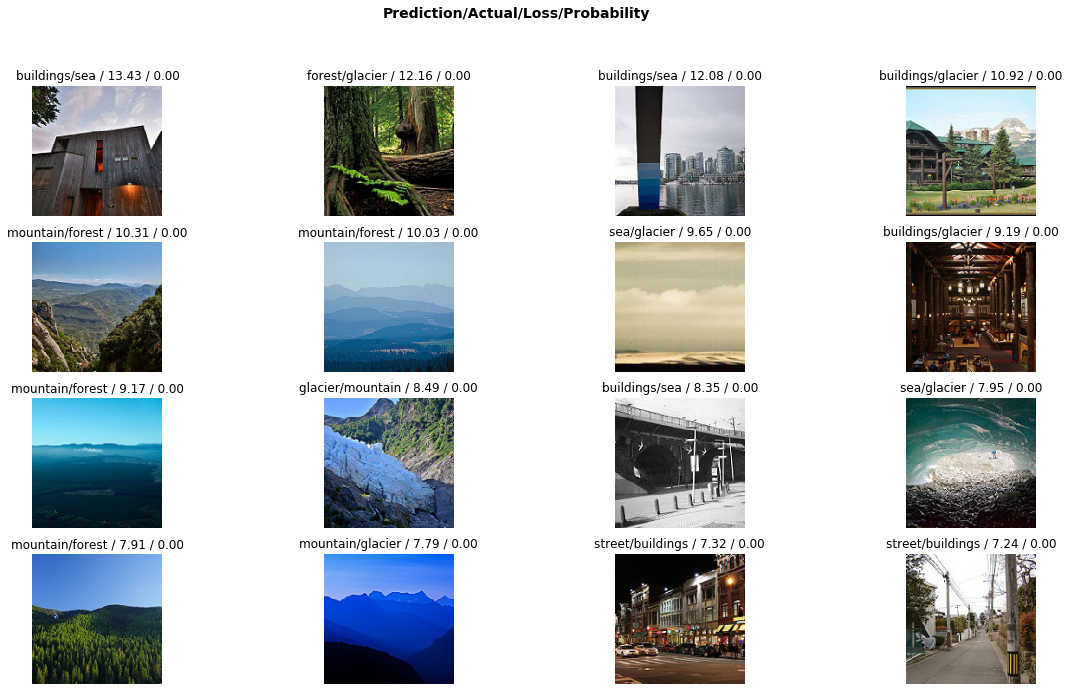

In [23]:
interp.plot_top_losses(16, figsize=(20,11))

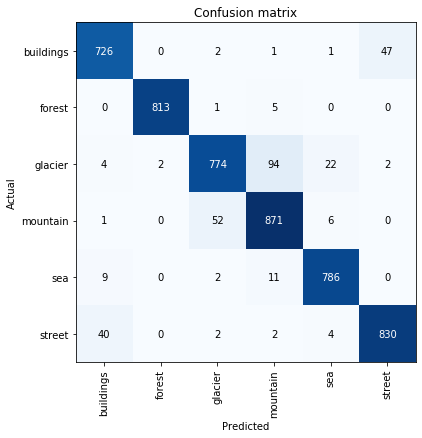

In [24]:
interp.plot_confusion_matrix(figsize=(8,6))

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


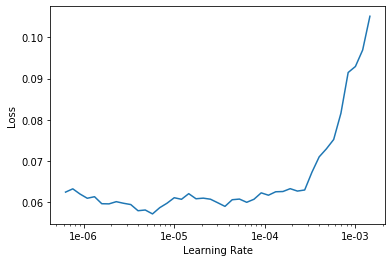

In [25]:
learn.lr_find()
learn.recorder.plot()

In [26]:
learn.freeze_to(-3)
learn.fit_one_cycle(5,1e-6)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.055836,0.194788,0.060274,0.939726,01:02
1,0.057682,0.192304,0.060470,0.939530,01:02
2,0.056231,0.195976,0.060078,0.939922,01:02
3,0.055175,0.192108,0.059295,0.940705,01:02
4,0.055407,0.194229,0.059100,0.940900,01:01


In [0]:
learn.save('model2')

In [28]:
learn.load('model2')

Learner(data=ImageDataBunch;

Train: LabelList (11924 items)
x: ImageList
Image (3, 140, 140),Image (3, 140, 140),Image (3, 140, 140),Image (3, 140, 140),Image (3, 140, 140)
y: CategoryList
forest,forest,forest,forest,forest
Path: /content/train/seg_train;

Valid: LabelList (5110 items)
x: ImageList
Image (3, 140, 140),Image (3, 140, 140),Image (3, 140, 140),Image (3, 140, 140),Image (3, 140, 140)
y: CategoryList
street,mountain,street,forest,glacier
Path: /content/train/seg_train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.

In [0]:
from fastai.widgets import *

In [0]:
np.random.seed(42)
db = ImageDataBunch.from_folder(path, train=".", valid_pct=0,
        ds_tfms=get_transforms(do_flip=True,max_warp=0.1), size=140, bs=128).normalize(imagenet_stats)

In [0]:
learn12 = cnn_learner(db, models.resnet50, metrics=[accuracy])
learn12.load('/content/train/model2');

In [65]:
ds, idxs = DatasetFormatter().from_toplosses(learn12)